## Surrogate Assisted Evolutionary Algorithms for CNN Hyperparameter Optimization

This notebook is used for running the EA and generating an evolved population. Visualizations are done in the `results.ipynb` notebook.

### Imports

In [1]:
from util import AlexNet, SmallCNN, get_loaders, train_model
from es import *
from surrogates import Surrogates
from copy import deepcopy

import oapackage
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import pickle
import os
import torch

### Create Training Data for Surrogate Models

Create a curated training population using hyperparameters close to default and recommended values

In [2]:
# check if saved file exists
if os.path.exists('curated_training_population.pkl'):
    with open('curated_training_population.pkl', 'rb') as f:
        training_population1 = pickle.load(f)
else:

    # Curated hyperparameters
    lrs = [0.01, 0.001, 0.0001]
    momentums = [0.9, 0.99, 0]
    weight_decays = [0.0005, 0.0001, 0]

    # Create a list of hyperparameter combinations
    hyperparams = []
    for lr in lrs:
        for momentum in momentums:
            for weight_decay in weight_decays:
                hyperparams.append((lr, momentum, weight_decay))

    hyperparams = np.array(hyperparams)

    # create training population from hyperparams
    training_population1 = [Genome(x=hyperparam) for hyperparam in hyperparams]

    # Update fitnesses using multiprocessing on full CNN  
    with ProcessPoolExecutor(TRAIN_CONCURRENT) as executor:
        results = list(tqdm(executor.map(fitness, training_population1), total=len(training_population1)))

    for i in range(len(training_population1)):
        training_population1[i].valid_acc = results[i][0]
        training_population1[i].train_acc = results[i][1]
        training_population1[i].train_loss = results[i][2]
        training_population1[i].loss_target_fitness = results[i][3]

    # save the population to a file
    with open('curated_training_population.pkl', 'wb') as f:
        pickle.dump(training_population1, f)

Create a random training population using uniform distributions for each hyperparameter (via default Genome constructor)

In [3]:
# check if saved file exists
if os.path.exists('random_training_population.pkl'):
    with open('random_training_population.pkl', 'rb') as f:
        training_population2 = pickle.load(f)
else:
    
    # Initialize population creation
    training_population2 = [Genome() for _ in range(100)]

    # Update fitnesses using multiprocessing on full CNN   
    with ProcessPoolExecutor(TRAIN_CONCURRENT) as executor:
        results = list(tqdm(executor.map(fitness, training_population2), total=len(training_population2)))

    # update the population with the results
    for i in range(len(training_population2)):
        training_population2[i].valid_acc = results[i][0]
        training_population2[i].train_acc = results[i][1]
        training_population2[i].train_loss = results[i][2]
        training_population2[i].loss_target_fitness = results[i][3]

    # save the population to a file
    with open('random_training_population.pkl', 'wb') as f:
        pickle.dump(training_population2, f)


Combine population

In [4]:
# combine the two populations
population = training_population1 + training_population2

In [5]:
# mean population validation accuracy
mean_valid_acc = np.mean([genome.valid_acc for genome in population])
print('Mean population validation accuracy: {}'.format(mean_valid_acc))

# mean population training accuracy
mean_train_acc = np.mean([genome.train_acc for genome in population])
print('Mean population training accuracy: {}'.format(mean_train_acc))

# mean population training loss
mean_train_loss = np.mean([genome.train_loss for genome in population])
print('Mean population training loss: {}'.format(mean_train_loss))

# mean population loss target fitness
mean_loss_target_fitness = np.mean([genome.loss_target_fitness for genome in population])
print('Mean population loss target fitness: {}'.format(mean_loss_target_fitness))

# max population validation accuracy
max_valid_acc = np.max([genome.valid_acc for genome in population])
print('Max population validation accuracy: {}'.format(max_valid_acc))

# max population training accuracy
max_train_acc = np.max([genome.train_acc for genome in population])
print('Max population training accuracy: {}'.format(max_train_acc))

# max population training loss
max_train_loss = np.max([genome.train_loss for genome in population])
print('Max population training loss: {}'.format(max_train_loss))

# max population loss target fitness
max_loss_target_fitness = np.max([genome.loss_target_fitness for genome in population])
print('Max population loss target fitness: {}'.format(max_loss_target_fitness))


Mean population validation accuracy: 37.30055016795481
Mean population training accuracy: 39.59373134703148
Mean population training loss: 1.3150466028160936
Mean population loss target fitness: 32.9878969732364
Max population validation accuracy: 73.66999816894531
Max population training accuracy: 88.12999725341797
Max population training loss: 2.327260732650757
Max population loss target fitness: 91.71355498721228


Find and visualize the pareto front

Pareto: 4 optimal values, 4 objects


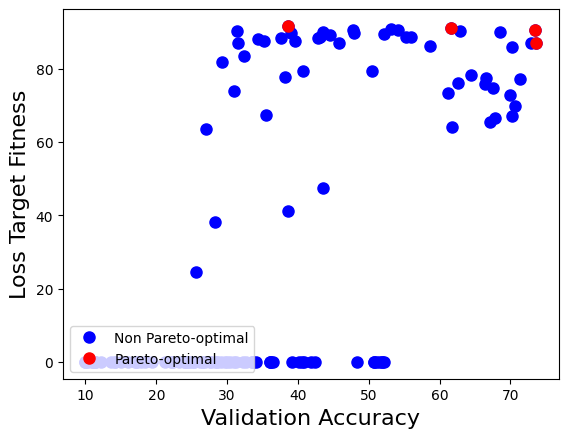

In [6]:
# find the pareto front
pareto=oapackage.ParetoDoubleLong()

for ii in range(0, len(population)):
    w=oapackage.doubleVector((population[ii].valid_acc, population[ii].loss_target_fitness))
    pareto.addvalue(w, ii)
# show the pareto front size 
pareto.show(verbose=1)

# show the pareto front visualization
pareto_front = [population[i] for i in pareto.allindices()]
h=plt.plot([genome.valid_acc for genome in population], [genome.loss_target_fitness for genome in population], '.b', markersize=16, label='Non Pareto-optimal')
h=plt.plot([genome.valid_acc for genome in pareto_front], [genome.loss_target_fitness for genome in pareto_front], '.r', markersize=16, label='Pareto-optimal')
plt.xlabel('Validation Accuracy', fontsize=16)
plt.ylabel('Loss Target Fitness', fontsize=16)
_=plt.legend(loc=3, numpoints=1)

### Build and Train Surrogate Models

In our experiments, we will use a support vector regressor (with RBF kernel), a gradient boosting regressor, a kernel ridge regressor (with RBF kernels) as our surrogate models. A voting ensemble will be used to combine the predictions of the three models. Because we have two objectives, we will train two models for each surrogate model type.

In [7]:
# initialize the surrogates model
surrogates = Surrogates()

# train the surrogates model
X = np.array([genome.x for genome in population])
y = np.array([[genome.valid_acc, genome.loss_target_fitness] for genome in population])

surrogates.train(X, y, verbose=True)


MSVR (RBF): Mean Absolute Error: 14.16 %.
MSVR (Laplacian): Mean Absolute Error: 11.11 %.
Random Forest Regressor: Mean Absolute Error: 11.97 %.


In [8]:
# save full trained population to a file. This file will updated anytime a new model is fully trained
fully_trained_population = []
fully_trained_population.append(deepcopy(population))
with open('fully_trained_population.pkl', 'wb') as f:
    pickle.dump(fully_trained_population, f)

### Evolutionary Algorithm: Initial Population and Statistics

In [9]:
# parameters come from es.py
mu=MU
lambda_=LAMBDA
sigma_crossover_rate=SIGMA_CROSSOVER_RATE
x_crossover_rate=X_CROSSOVER_RATE
sigma_mutation_rate=SIGMA_MUTATION_RATE
x_mutation_rate=X_MUTATION_RATE
max_generations=MAX_GENERATIONS
converge_threshold=CONVERGE_THRESHOLD
display_stats=True
retrain_frequency=RETRAIN_FREQUENCY
train_concurrent=TRAIN_CONCURRENT

# Initialize population creation
population = [Genome() for _ in range(mu)]

# Update fitnesses via surrogates model
X = np.array([genome.x for genome in population])
y_pred = surrogates.predict(X)
for i in range(len(population)):
    population[i].valid_acc = y_pred[i][0]
    population[i].loss_target_fitness = y_pred[i][1]


# Initialize lists to store generational statistics
generational_valid_acc_max = []
generational_valid_acc_min = []
generational_valid_acc_mean = []

generational_loss_target_max = []
generational_loss_target_min = []
generational_loss_target_mean = []

generational_pareto_fronts = []
generational_diversity = []

generational_surrogate_mae = []

# get statistics about initial generation
vaild_accs = [genome.valid_acc for genome in population]
loss_targets = [genome.loss_target_fitness for genome in population]

generational_valid_acc_max.append(max(vaild_accs))
generational_valid_acc_min.append(min(vaild_accs))
generational_valid_acc_mean.append(np.mean(vaild_accs))

generational_loss_target_max.append(max(loss_targets))
generational_loss_target_min.append(min(loss_targets))
generational_loss_target_mean.append(np.mean(loss_targets))

generational_pareto_fronts.append(pareto_front)
generational_diversity.append(get_population_diversity(population))

generational_surrogate_mae.append(surrogates.get_mae())

### Evolutionary Algorithm: Main Loop

In [10]:
for gen_count in range(max_generations):
    # print generational stats
    if display_stats:
        print(f'{gen_count} {generational_valid_acc_min[-1]:.4f} {generational_valid_acc_mean[-1]:.4f} {generational_valid_acc_max[-1]:.4f}',
                f'{generational_loss_target_min[-1]:.4f} {generational_loss_target_mean[-1]:.4f} {generational_loss_target_max[-1]:.4f} {generational_diversity[-1]:.4f}')
        
    # container to store new generation
    new_population = []

    # loop to create new generation of size lambda_
    for i in range(lambda_ // 2):
        # Uniform random parent selection
        parent_1_idx = np.random.randint(0, len(population))
        parent_2_idx = np.random.randint(0, len(population))

        parent_1 = deepcopy(population[parent_1_idx])
        parent_2 = deepcopy(population[parent_2_idx])

        # sigma crossover (intermediate recombination)
        sigma_crossover(parent_1, parent_2, crossover_rate=sigma_crossover_rate)

        # sigma mutation 
        sigma_mutate(parent_1, mutation_rate=sigma_mutation_rate)
        sigma_mutate(parent_2, mutation_rate=sigma_mutation_rate)
        
        # x crossover intermediate recombination
        crossover(parent_1, parent_2, crossover_rate=x_crossover_rate)

        # x mutation
        mutate(parent_1, mutation_rate=x_mutation_rate)
        mutate(parent_2, mutation_rate=x_mutation_rate)
            
        # add to new generation
        new_population.append(parent_1)
        new_population.append(parent_2)

    # limit genome X values to be within bounds
    for genome in new_population:
        genome.x[0] = np.clip(genome.x[0], 0, 0.2)
        genome.x[1] = np.clip(genome.x[1], 0, 0.999)
        genome.x[2] = np.clip(genome.x[2], 0, 0.05)

    # Update fitnesses via surrogates model
    X = np.array([genome.x for genome in new_population])
    y_pred = surrogates.predict(X)
    for i in range(len(new_population)):
        new_population[i].valid_acc = y_pred[i][0]
        new_population[i].loss_target_fitness = y_pred[i][1]
    
    # add new generation to population
    population.extend(new_population)

    # find the pareto front
    pareto=oapackage.ParetoDoubleLong()
    for ii in range(0, len(population)):
        w=oapackage.doubleVector((population[ii].valid_acc, population[ii].loss_target_fitness))
        pareto.addvalue(w, ii)

    pareto_front = [population[ii] for ii in pareto.allindices()]

    # chose the top mu/2 from the pareto front based on crowding distance
    X = np.array([genome.x for genome in pareto_front])
    distances = CrowdingDist(X)
    new_front = []
    sorted_indexes = np.argsort(distances)[::-1]
    for idx in sorted_indexes[:int(mu / 2)]:
        new_front.append(pareto_front[idx])
    pareto_front = new_front

    # create a new population consisting of the pareto front, the top validation accuracy, and the top loss target fitness
    new_population = [genome for genome in pareto_front]

    sorted1 = sorted(population, key=lambda genome: genome.valid_acc, reverse=True)
    sorted2 = sorted(population, key=lambda genome: genome.loss_target_fitness, reverse=True)
    while len(new_population) < mu-1:
        new_population.append(sorted1.pop(0))
        new_population.append(sorted2.pop(0))
        new_population = list(set(new_population))

    population = new_population

    # every retrain_frequency generations, retrain the surrogates model using full CNN training
    if gen_count > 0 and gen_count % retrain_frequency == 0:

        # Update fitnesses using multiprocessing on full CNN  
        with ProcessPoolExecutor(train_concurrent) as executor:
            results = list(tqdm(executor.map(fitness, population), total=len(population)))
        
        # update fitnesses with results
        for i in range(len(population)):
            population[i].valid_acc = results[i][0]
            population[i].loss_target_fitness = results[i][1]
        
        # update surrogates model
        X = np.array([genome.x for genome in population])
        y = np.array([[genome.valid_acc, genome.loss_target_fitness] for genome in population])
        surrogates.train(X, y)

        # update pareto front
        pareto=oapackage.ParetoDoubleLong()
        for ii in range(0, len(population)):
            w=oapackage.doubleVector((population[ii].valid_acc, population[ii].loss_target_fitness))
            pareto.addvalue(w, ii)

        pareto_front = [population[ii] for ii in pareto.allindices()]

        # save fully trained population
        fully_trained_population.append(deepcopy(population))
        with open('fully_trained_population.pkl', 'wb') as f:
            pickle.dump(fully_trained_population, f) 

        # Pickle generational statistics and save to file
        with open(f'generational_stats.pkl', 'wb') as f: 
            pickle.dump((generational_valid_acc_max, generational_valid_acc_min, generational_valid_acc_mean,
                        generational_loss_target_max, generational_loss_target_min, generational_loss_target_mean,
                        generational_pareto_fronts,  generational_diversity, generational_surrogate_mae), f)


    # get statistics about new population
    vaild_accs = [genome.valid_acc for genome in population]
    loss_targets = [genome.loss_target_fitness for genome in population]

    generational_valid_acc_max.append(max(vaild_accs))
    generational_valid_acc_min.append(min(vaild_accs))
    generational_valid_acc_mean.append(np.mean(vaild_accs))

    generational_loss_target_max.append(max(loss_targets))
    generational_loss_target_min.append(min(loss_targets))
    generational_loss_target_mean.append(np.mean(loss_targets))

    generational_pareto_fronts.append(pareto_front)
    generational_diversity.append(get_population_diversity(population))

    generational_surrogate_mae.append(surrogates.get_mae())

    # Check for termination conditions
    # (1) - terminate if generational diversity is below threshold
    # if generational_diversity[-1] < converge_threshold :
    #     if display_stats:
    #         print(f'Population has converged with generational diversity below threshold of {converge_threshold }')
    #     break

    # (2) - terminate after max_generations (display message)
    if gen_count == max_generations - 1 and display_stats:
        print('The maximum number of generations has been reached')

# Pickle generational statistics and save to file
with open(f'generational_stats.pkl', 'wb') as f: 
    pickle.dump((generational_valid_acc_max, generational_valid_acc_min, generational_valid_acc_mean,
                generational_loss_target_max, generational_loss_target_min, generational_loss_target_mean,
                generational_pareto_fronts,  generational_diversity, generational_surrogate_mae), f)



0 17.9526 36.7683 66.0096 0.0000 26.6266 100.0000 0.8404
1 35.7703 54.1001 67.7209 4.4298 80.1761 100.0000 0.4096
2 40.9558 55.4564 67.7209 62.6289 90.9275 100.0000 0.3562
3 40.9558 55.2450 67.7209 62.6289 90.9735 100.0000 0.3567
4 40.9558 55.3869 67.7209 62.6289 90.8186 100.0000 0.3137
5 40.9558 55.3869 67.7209 62.6289 90.8186 100.0000 0.3137
6 40.9558 55.6074 67.7209 62.6289 90.1608 100.0000 0.4235
7 40.9558 55.6074 67.7209 62.6289 90.1608 100.0000 0.4235
8 40.9558 55.7141 67.7209 62.4860 89.1568 100.0000 0.4235
9 40.9558 55.7141 67.7209 62.4860 89.1568 100.0000 0.4235
10 40.9558 55.7141 67.7209 62.4860 89.1568 100.0000 0.4235
11 40.9558 55.7141 67.7209 62.4860 89.1568 100.0000 0.4235
12 40.9558 55.7986 67.7209 62.6289 89.2360 100.0000 0.5404
13 40.9558 55.7986 67.7209 62.6289 89.2360 100.0000 0.5404
14 40.9558 55.7986 67.7209 62.6289 89.2360 100.0000 0.5404
15 40.9558 55.7986 67.7209 62.6289 89.2360 100.0000 0.5404
16 40.9558 55.7986 67.7209 62.6289 89.2360 100.0000 0.5404
17 40.955

100%|██████████| 20/20 [14:48<00:00, 44.44s/it]  


MSVR (RBF): Mean Absolute Error: 11.21 %.
MSVR (Laplacian): Mean Absolute Error: 5.93 %.
Random Forest Regressor: Mean Absolute Error: 5.83 %.
1001 10.8900 48.2475 69.1000 10.8360 53.8950 81.9260 0.7648
1002 64.4318 66.9233 69.1000 75.2360 78.0941 81.9260 0.6493
1003 64.6818 67.0538 69.1000 76.2154 78.2338 81.9260 0.6493
1004 64.7137 67.2339 69.1000 76.2427 78.4220 81.9260 0.6493
1005 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1006 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1007 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1008 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1009 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1010 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1011 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1012 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1013 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1014 66.2516 67.3388 69.1000 76.7249 78.4932 81.9260 0.5862
1015 66.6421 67.4

100%|██████████| 20/20 [14:49<00:00, 44.47s/it]  


MSVR (RBF): Mean Absolute Error: 5.68 %.
MSVR (Laplacian): Mean Absolute Error: 5.19 %.
Random Forest Regressor: Mean Absolute Error: 3.81 %.
2001 50.6300 63.4840 71.0200 58.5020 74.7052 85.1020 0.5749
2002 64.1598 66.6171 71.0200 76.0460 79.0311 85.1020 0.2325
2003 64.2638 66.6795 71.0200 76.0460 79.0731 85.1020 0.2325
2004 64.2638 66.5882 71.0200 76.0460 78.9608 85.1020 0.2325
2005 64.2638 66.7811 71.0200 76.9282 79.2355 85.1020 0.2325
2006 65.4817 67.3540 71.0200 77.0820 79.8947 85.1020 0.2136
2007 65.9010 67.6265 71.0200 77.3460 80.3387 85.1020 0.1715
2008 66.5905 67.7626 71.0200 78.9575 80.5766 85.1020 0.1560
2009 66.5905 67.8202 71.0200 79.0695 80.6953 85.1020 0.1689
2010 66.6554 67.9988 71.0200 79.3300 80.9066 85.1020 0.1689
2011 66.7609 68.0606 71.0200 79.3300 81.0118 85.1020 0.1591
2012 67.2147 68.3409 71.0200 79.9900 81.4440 85.1020 0.1592
2013 67.4881 68.4949 71.0200 80.5812 81.6239 85.1020 0.1592
2014 67.4881 68.4949 71.0200 80.5812 81.6239 85.1020 0.1592
2015 67.6845 68.89

100%|██████████| 20/20 [14:47<00:00, 44.39s/it]  


MSVR (RBF): Mean Absolute Error: 3.74 %.
MSVR (Laplacian): Mean Absolute Error: 2.94 %.
Random Forest Regressor: Mean Absolute Error: 2.16 %.
3001 54.8000 64.9900 69.4200 63.4940 75.8324 82.3760 0.2328
3002 66.4517 67.2319 69.4200 78.4781 79.3510 82.3760 0.2291
3003 66.4517 67.2319 69.4200 78.4781 79.3510 82.3760 0.2291
3004 66.7163 67.3317 69.4200 78.7423 79.5055 82.3760 0.2266
3005 66.7163 67.3317 69.4200 78.7423 79.5055 82.3760 0.2266
3006 66.7163 67.3317 69.4200 78.7423 79.5055 82.3760 0.2266
3007 66.6637 67.3396 69.4200 78.7423 79.5380 82.3760 0.2323
3008 66.6637 67.3439 69.4200 78.0251 79.5334 82.3760 0.2342
3009 66.6637 67.3220 69.4200 78.0251 79.5190 82.3760 0.2348
3010 66.6637 67.3552 69.4200 78.0251 79.5505 82.3760 0.2342
3011 66.6637 67.3648 69.4200 78.0251 79.5658 82.3760 0.2343
3012 66.8596 67.4013 69.4200 78.0251 79.5949 82.3760 0.2343
3013 66.8629 67.4074 69.4200 78.9160 79.6735 82.3760 0.2371
3014 66.9472 67.4870 69.4200 78.9160 79.7503 82.3760 0.2377
3015 66.9472 67.48

100%|██████████| 19/19 [14:45<00:00, 46.62s/it]  


MSVR (RBF): Mean Absolute Error: 5.97 %.
MSVR (Laplacian): Mean Absolute Error: 4.73 %.
Random Forest Regressor: Mean Absolute Error: 4.75 %.
4001 51.4100 64.4505 72.4800 59.2640 75.4222 85.0500 0.2386
4002 67.4423 68.4970 72.4800 79.2552 80.5712 85.0500 0.2430
4003 67.4437 68.7377 72.4800 79.8340 81.0261 85.0500 0.2470
4004 68.4745 69.2273 72.4800 80.5060 81.5079 85.0500 0.2470
4005 68.4745 69.4783 72.4800 80.8812 82.0675 85.0500 0.2524
4006 68.4745 69.4783 72.4800 80.8812 82.0675 85.0500 0.2524
4007 68.4745 69.4783 72.4800 80.8812 82.0675 85.0500 0.2524
4008 68.4745 69.5063 72.4800 80.8045 82.0791 85.0500 0.2524
4009 68.4745 69.5503 72.4800 80.9674 82.1195 85.0500 0.2524
4010 68.4745 69.5596 72.4800 81.0279 82.1306 85.0500 0.2524
4011 68.4745 69.5596 72.4800 81.0279 82.1306 85.0500 0.2524
4012 68.4745 69.5692 72.4800 81.0279 82.1336 85.0500 0.2524
4013 68.4745 69.5692 72.4800 81.0279 82.1336 85.0500 0.2524
4014 68.4745 69.5692 72.4800 81.0279 82.1336 85.0500 0.2524
4015 68.4745 69.56

100%|██████████| 19/19 [14:46<00:00, 46.67s/it]  


MSVR (RBF): Mean Absolute Error: 3.18 %.
MSVR (Laplacian): Mean Absolute Error: 3.75 %.
Random Forest Regressor: Mean Absolute Error: 1.09 %.
5001 57.9200 64.6900 70.4700 66.7300 75.9134 82.7840 0.3857
5002 66.1953 67.2692 70.4700 77.7386 79.3853 82.7840 0.3764
5003 66.1953 67.3366 70.4700 77.9988 79.4666 82.7840 0.3764
5004 66.1953 67.6276 70.4700 77.9988 79.9988 82.7840 0.3764
5005 66.6181 68.3358 70.4700 78.8350 80.9268 82.7840 0.3764
5006 67.6800 68.6823 70.4700 80.4364 81.4819 82.7840 0.3580
5007 67.6800 68.7006 70.4700 80.6121 81.5041 82.7840 0.3580
5008 67.6800 68.7006 70.4700 80.6121 81.5041 82.7840 0.3580
5009 67.6800 68.7006 70.4700 80.6121 81.5041 82.7840 0.3580
5010 67.8951 68.7175 70.4700 80.3331 81.4464 82.7840 0.3580
5011 67.8951 68.7175 70.4700 80.3331 81.4464 82.7840 0.3580
5012 68.0279 68.8279 70.4700 80.4189 81.5496 82.7840 0.3580
5013 68.0279 68.8889 70.4700 80.7138 81.6257 82.7840 0.3580
5014 68.2282 69.1285 70.4700 80.9027 81.9087 82.9049 0.3580
5015 68.7929 69.54

100%|██████████| 20/20 [14:51<00:00, 44.59s/it]  


MSVR (RBF): Mean Absolute Error: 6.79 %.
MSVR (Laplacian): Mean Absolute Error: 4.27 %.
Random Forest Regressor: Mean Absolute Error: 3.34 %.
6001 53.9300 63.6875 70.1100 63.0640 74.5939 83.4380 0.0035
6002 64.2759 66.8440 70.1100 75.6311 78.8067 83.4380 0.0009
6003 65.4549 67.1744 70.1100 76.5088 79.2053 83.4380 0.0012
6004 65.4549 67.3601 70.1100 77.2992 79.6238 83.4380 0.0012
6005 65.6522 67.3869 70.1100 77.6139 79.6550 83.4380 0.0009
6006 65.7454 67.5499 70.1100 77.6677 79.9001 83.4380 0.0009
6007 66.1891 67.7347 70.1100 77.8280 80.1906 83.4380 0.0009
6008 66.8933 68.2533 70.1100 79.2133 81.0162 83.4380 0.0009
6009 66.8933 68.2533 70.1100 79.2133 81.0162 83.4380 0.0009
6010 67.2980 68.4196 70.1100 80.0257 81.2248 83.4380 0.0009
6011 67.2980 68.4196 70.1100 80.0257 81.2248 83.4380 0.0009
6012 67.4186 68.4768 70.1100 80.2780 81.3087 83.4380 0.0009
6013 67.4186 68.4901 70.1100 80.2780 81.3151 83.4380 0.0009
6014 67.4186 68.4901 70.1100 80.2780 81.3151 83.4380 0.0009
6015 67.4186 68.50

100%|██████████| 19/19 [14:51<00:00, 46.92s/it]  


MSVR (RBF): Mean Absolute Error: 8.66 %.
MSVR (Laplacian): Mean Absolute Error: 10.92 %.
Random Forest Regressor: Mean Absolute Error: 2.96 %.
7001 53.1900 64.4711 71.6100 59.1880 75.4868 85.2600 0.0017
7002 65.8525 67.7627 71.6100 78.0426 80.4514 85.2600 0.0016
7003 65.7544 67.8861 71.6100 79.2132 80.7466 85.2600 0.0016
7004 67.0568 68.2108 71.6100 79.5536 81.3216 85.2600 0.0016
7005 67.9904 69.2547 71.6100 80.8560 82.9021 85.2600 0.0016
7006 68.2907 69.2934 71.6100 80.8560 82.9112 85.2600 0.0016
7007 68.2907 69.2618 71.6100 80.8560 82.8752 85.2600 0.0016
7008 68.5650 69.3133 71.6100 80.8560 83.0048 85.2600 0.0016
7009 68.5650 69.3133 71.6100 80.8560 83.0048 85.2600 0.0016
7010 68.5650 69.3133 71.6100 80.8560 83.0048 85.2600 0.0016
7011 68.5650 69.3133 71.6100 80.8560 83.0048 85.2600 0.0016
7012 68.5650 69.3133 71.6100 80.8560 83.0048 85.2600 0.0016
7013 68.5650 69.3133 71.6100 80.8560 83.0048 85.2600 0.0016
7014 68.5650 69.3133 71.6100 80.8560 83.0048 85.2600 0.0016
7015 68.5650 69.3

100%|██████████| 20/20 [15:06<00:00, 45.34s/it]  


MSVR (RBF): Mean Absolute Error: 19.38 %.
MSVR (Laplacian): Mean Absolute Error: 16.3 %.
Random Forest Regressor: Mean Absolute Error: 2.36 %.
8001 53.4100 63.4225 70.3000 60.3120 74.4688 83.0280 0.0020
8002 64.5200 66.0872 70.3000 75.5680 78.0733 83.0280 0.0007
8003 64.9945 66.2787 70.3000 76.9335 78.4150 83.0280 0.0007
8004 65.4899 66.5413 70.3000 76.9335 78.7054 83.0280 0.0007
8005 65.5300 66.7320 70.3000 77.2406 78.9832 83.0280 0.0007
8006 65.8300 66.8163 70.3000 77.8143 79.1108 83.0280 0.0007
8007 65.9304 66.8868 70.3000 78.0464 79.2434 83.0280 0.0007
8008 65.9304 66.9337 70.3000 78.0464 79.3194 83.0280 0.0002
8009 66.0874 67.0128 70.3000 78.3028 79.4096 83.0280 0.0002
8010 66.3617 67.0823 70.3000 78.3028 79.4933 83.0280 0.0002
8011 66.4239 67.1173 70.3000 78.6620 79.5849 83.0280 0.0002
8012 66.4239 67.1173 70.3000 78.6620 79.5849 83.0280 0.0002
8013 66.4239 67.1628 70.3000 78.7603 79.6621 83.0280 0.0002
8014 66.5355 67.1687 70.3000 78.7603 79.6643 83.0280 0.0002
8015 66.7390 67.1

100%|██████████| 20/20 [15:09<00:00, 45.46s/it]  


MSVR (RBF): Mean Absolute Error: 2.38 %.
MSVR (Laplacian): Mean Absolute Error: 3.1 %.
Random Forest Regressor: Mean Absolute Error: 3.31 %.
9001 56.8100 65.2775 71.6800 65.0320 76.4557 85.1780 0.0003
9002 65.5500 67.5340 71.6800 77.6300 79.5244 85.1780 0.0003
9003 65.5500 67.9975 71.6800 78.4874 80.1293 85.1780 0.0003
9004 65.5500 68.0638 71.6800 78.4874 80.2160 85.1780 0.0003
9005 67.0593 68.3096 71.6800 78.8928 80.4408 85.1780 0.0003
9006 67.1884 68.4771 71.6800 79.0558 80.7528 85.1780 0.0003
9007 67.5549 68.5766 71.6800 79.4400 80.8858 85.1780 0.0003
9008 67.5549 68.5766 71.6800 79.4400 80.8858 85.1780 0.0003
9009 67.8443 68.7976 71.6800 79.8667 81.1540 85.1780 0.0003
9010 67.8443 68.7976 71.6800 79.8667 81.1540 85.1780 0.0003
9011 67.8443 68.8776 71.6800 79.9566 81.2296 85.1780 0.0003
9012 68.1485 68.9124 71.6800 80.1446 81.3022 85.1780 0.0003
9013 68.1510 68.9537 71.6800 80.3201 81.3977 85.1780 0.0003
9014 68.0127 68.9145 71.6800 80.3201 81.4254 85.1780 0.0003
9015 68.0127 68.914

100%|██████████| 19/19 [15:01<00:00, 47.44s/it]  


MSVR (RBF): Mean Absolute Error: 4.66 %.
MSVR (Laplacian): Mean Absolute Error: 4.07 %.
Random Forest Regressor: Mean Absolute Error: 4.34 %.
10001 49.6800 63.4595 70.5800 57.1680 74.3657 84.6460 0.0003
10002 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10003 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10004 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10005 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10006 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10007 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10008 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10009 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10010 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10011 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10012 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10013 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
10014 66.5868 67.4340 70.5800 78.1620 79.4683 84.6460 0.0000
1001

100%|██████████| 20/20 [15:07<00:00, 45.38s/it]  


MSVR (RBF): Mean Absolute Error: 6.46 %.
MSVR (Laplacian): Mean Absolute Error: 7.36 %.
Random Forest Regressor: Mean Absolute Error: 5.67 %.
11001 49.7400 64.4330 71.0200 57.5040 76.0007 84.9220 0.0000
11002 64.7100 67.7231 71.0200 76.8040 80.4450 84.9220 0.0000
11003 68.0730 68.8263 71.0200 80.7691 81.9275 84.9220 0.0000
11004 68.1471 68.8813 71.0200 80.7779 82.0351 84.9220 0.0000
11005 68.4190 68.9102 71.0200 81.1655 82.1015 84.9220 0.0000
11006 68.3280 68.9014 71.0200 81.2241 82.1199 84.9220 0.0000
11007 68.3280 68.9031 71.0200 81.0992 82.1124 84.9220 0.0000
11008 68.4117 68.9239 71.0200 81.0992 82.1204 84.9220 0.0000
11009 68.4117 68.9578 71.0200 81.2241 82.1616 84.9220 0.0000
11010 68.4117 68.9578 71.0200 81.2241 82.1616 84.9220 0.0000
11011 68.4908 68.9660 71.0200 81.2241 82.1642 84.9220 0.0000
11012 68.4908 69.0424 71.0200 81.1525 82.2062 84.9220 0.0000
11013 68.4908 69.0424 71.0200 81.1525 82.2062 84.9220 0.0000
11014 68.4908 69.0276 71.0200 81.1525 82.1739 84.9220 0.0000
1101

100%|██████████| 20/20 [15:13<00:00, 45.67s/it]  


MSVR (RBF): Mean Absolute Error: 5.49 %.
MSVR (Laplacian): Mean Absolute Error: 7.27 %.
Random Forest Regressor: Mean Absolute Error: 6.73 %.
12001 36.2200 63.8155 72.0500 41.1700 74.9114 85.8640 0.0000
12002 63.9376 66.4334 72.0500 74.5692 78.2176 85.8640 0.0000
12003 65.1000 67.0968 72.0500 76.2740 79.2553 85.8640 0.0000
12004 65.7500 67.1432 72.0500 76.2740 79.2579 85.8640 0.0000
12005 65.7500 67.2639 72.0500 76.2740 79.3934 85.8640 0.0000
12006 65.7500 67.2639 72.0500 76.2740 79.3934 85.8640 0.0000
12007 65.7500 67.3035 72.0500 76.2740 79.4488 85.8640 0.0000
12008 65.7500 67.3502 72.0500 76.2740 79.4889 85.8640 0.0000
12009 65.7500 67.4434 72.0500 77.6426 79.6404 85.8640 0.0000
12010 65.7500 67.4434 72.0500 77.6426 79.6404 85.8640 0.0000
12011 65.7500 67.5208 72.0500 77.8865 79.7485 85.8640 0.0000
12012 65.7500 67.4908 72.0500 77.8865 79.6957 85.8640 0.0000
12013 65.7500 67.4908 72.0500 77.8865 79.6957 85.8640 0.0000
12014 66.7042 67.6113 72.0500 78.3353 79.8352 85.8640 0.0000
1201

100%|██████████| 20/20 [15:02<00:00, 45.14s/it]  


MSVR (RBF): Mean Absolute Error: 5.24 %.
MSVR (Laplacian): Mean Absolute Error: 5.52 %.
Random Forest Regressor: Mean Absolute Error: 4.79 %.
13001 53.2800 63.0810 70.4500 61.0300 73.8825 84.8580 0.0000
13002 65.7100 68.2035 70.4500 79.2062 81.4999 84.8580 0.0000
13003 65.7100 68.2893 70.4500 79.2062 81.5950 84.8580 0.0000
13004 65.7100 68.3374 70.4500 79.4600 81.6963 84.8580 0.0000
13005 65.7100 68.3180 70.4500 79.4600 81.7722 84.8580 0.0000
13006 66.9713 68.5246 70.4500 80.4574 82.0052 84.8580 0.0000
13007 67.4827 68.8574 70.4500 81.3876 82.4197 84.8580 0.0000
13008 67.7692 69.0194 70.4500 81.3876 82.5557 84.8580 0.0000
13009 67.7692 69.0399 70.4500 81.3876 82.5352 84.8580 0.0000
13010 67.8612 69.2128 70.4500 81.8970 82.7367 84.8580 0.0000
13011 68.6286 69.3544 70.4500 82.2223 82.9593 84.8580 0.0000
13012 68.9970 69.4939 70.4500 82.4488 83.1198 84.8580 0.0000
13013 68.9970 69.5112 70.4500 82.5638 83.1613 84.8580 0.0000
13014 68.9970 69.5220 70.4500 82.6298 83.1760 84.8580 0.0000
1301

100%|██████████| 19/19 [15:05<00:00, 47.65s/it]  


MSVR (RBF): Mean Absolute Error: 19.1 %.
MSVR (Laplacian): Mean Absolute Error: 17.17 %.
Random Forest Regressor: Mean Absolute Error: 8.78 %.
14001 44.1500 61.7584 70.4600 49.2080 72.3176 82.6380 0.0000
14002 62.9976 66.3202 70.4600 73.1779 77.9857 82.6380 0.0000
14003 64.7381 67.3321 70.4600 75.7616 79.3615 82.6380 0.0000
14004 64.7381 68.0151 70.7966 76.6711 80.3232 83.4491 0.0000
14005 65.9055 68.8521 70.7966 78.0311 81.3180 83.4491 0.0000
14006 66.8800 69.5940 70.8438 80.0710 82.1023 83.8608 0.0000
14007 66.8800 69.8577 71.1909 80.0710 82.3824 84.1009 0.0000
14008 66.8800 69.9521 71.1909 80.5041 82.5179 84.1009 0.0000
14009 69.2900 70.4232 71.8341 82.2171 82.9833 84.6078 0.0000
14010 69.3900 70.6055 71.8341 82.2171 83.1263 84.6078 0.0000
14011 69.9363 70.6329 71.8341 82.2171 83.1638 84.6078 0.0000
14012 69.9363 70.6329 71.8341 82.2171 83.1638 84.6078 0.0000
14013 69.9363 70.6329 71.8341 82.2171 83.1638 84.6078 0.0000
14014 69.9363 70.6329 71.8341 82.2171 83.1638 84.6078 0.0000
140

In [11]:
len(pareto_front)

5

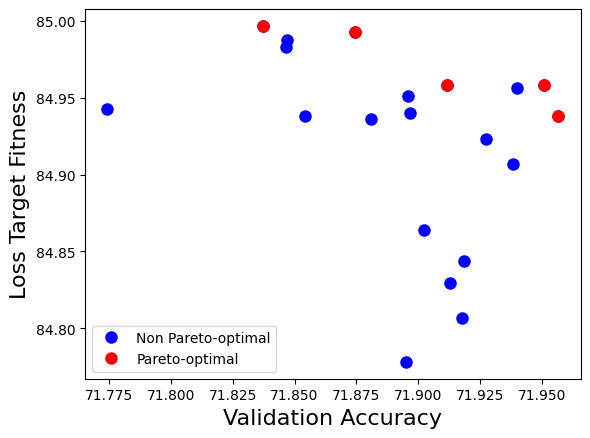

In [15]:

# for pareto_front in generational_pareto_fronts:
#     plt.figure(figsize=(8,8))
#     plt.plot([genome.valid_acc for genome in pareto_front], [genome.loss_target_fitness for genome in pareto_front], '.r', markersize=16, label='Pareto-optimal')
#     plt.xlabel('Validation Accuracy', fontsize=16)
#     plt.ylabel('Loss Target Fitness', fontsize=16)
#     _=plt.legend(loc=3, numpoints=1)
pareto_front = generational_pareto_fronts[-1]
plt.plot([genome.valid_acc for genome in population], [genome.loss_target_fitness for genome in population], '.b', markersize=16, label='Non Pareto-optimal')
plt.plot([genome.valid_acc for genome in pareto_front], [genome.loss_target_fitness for genome in pareto_front], '.r', markersize=16, label='Pareto-optimal')
plt.xlabel('Validation Accuracy', fontsize=16)
plt.ylabel('Loss Target Fitness', fontsize=16)
_=plt.legend(loc=3, numpoints=1)

Text(0, 0.5, 'Diversity')

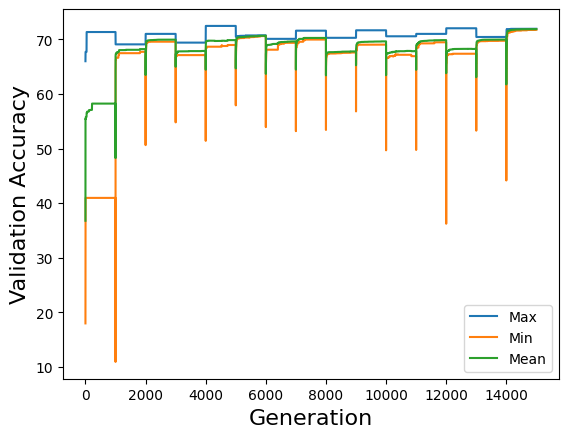

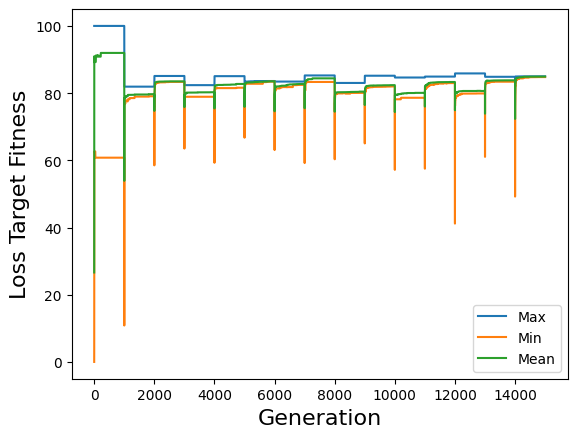

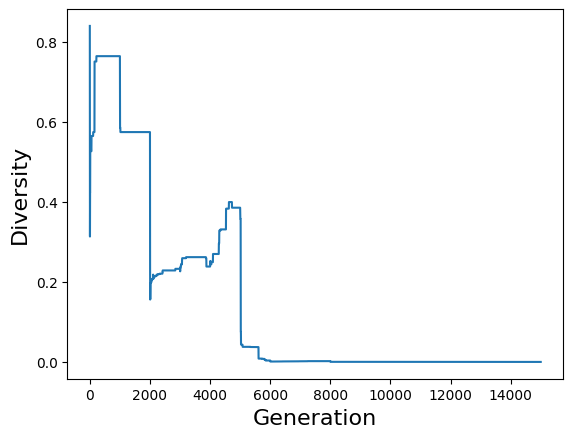

In [13]:
# graph generational statistics
plt.figure()
plt.plot(generational_valid_acc_max, label='Max')
plt.plot(generational_valid_acc_min, label='Min')
plt.plot(generational_valid_acc_mean, label='Mean')
plt.xlabel('Generation', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=16)
plt.legend(loc=4, numpoints=1)

plt.figure()
plt.plot(generational_loss_target_max, label='Max')
plt.plot(generational_loss_target_min, label='Min')
plt.plot(generational_loss_target_mean, label='Mean')
plt.xlabel('Generation', fontsize=16)
plt.ylabel('Loss Target Fitness', fontsize=16)
plt.legend(loc=4, numpoints=1)


# graph generational diversity
plt.figure()
plt.plot(generational_diversity)
plt.xlabel('Generation', fontsize=16)
plt.ylabel('Diversity', fontsize=16)



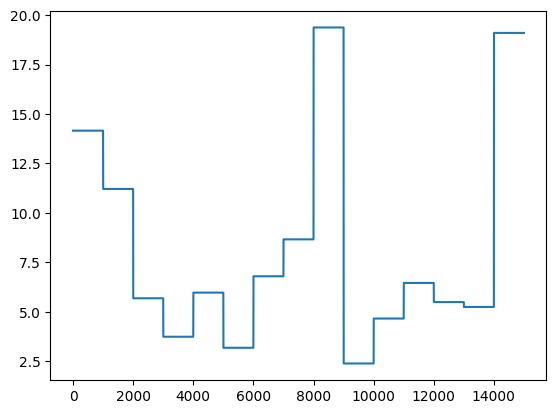

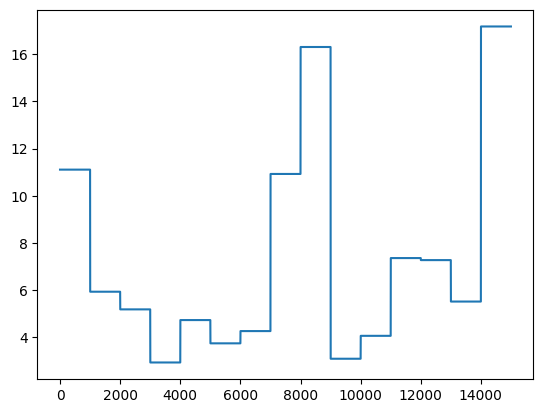

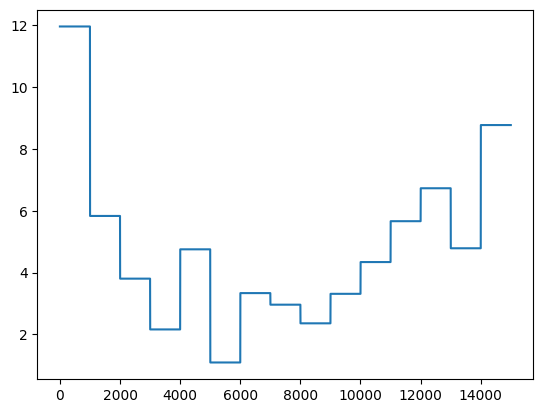

In [14]:
# plot surrogate MAE
plt.figure()
plt.plot([mae['msvr_rbf'] for mae in generational_surrogate_mae])
plt.figure()
plt.plot([mae['msvr_laplace'] for mae in generational_surrogate_mae])
plt.figure()
plt.plot([mae['rfr'] for mae in generational_surrogate_mae])
